# Maximum likelihood estimation and least square fitting
- based on http://dan.iel.fm/emcee/current/user/line/
- see also [Numerical Recipes](http://apps.nrbook.com/c/index.html) chapter 15: Modelling of Data

In [36]:
#import emcee
#import corner
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
#from matplotlib.ticker import MaxNLocator
%matplotlib inline
import matplotlib
matplotlib.rc('font', size=16)
#matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['figure.figsize'] =(18,6)

# Reproducible results!
np.random.seed(123456)

In [37]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))

y = m_true*x+b_true

# Error with Gaussian distribution
yerr = 0.5*np.random.randn(N)

# The ideal case: only Gaussian errors
y_gauss = y + yerr

# additional error that is proportional to y value
y_complex = y + np.abs(f_true*y) * np.random.randn(N)
# also make Gaussian 
y_complex = y_complex + yerr 
y = y_complex

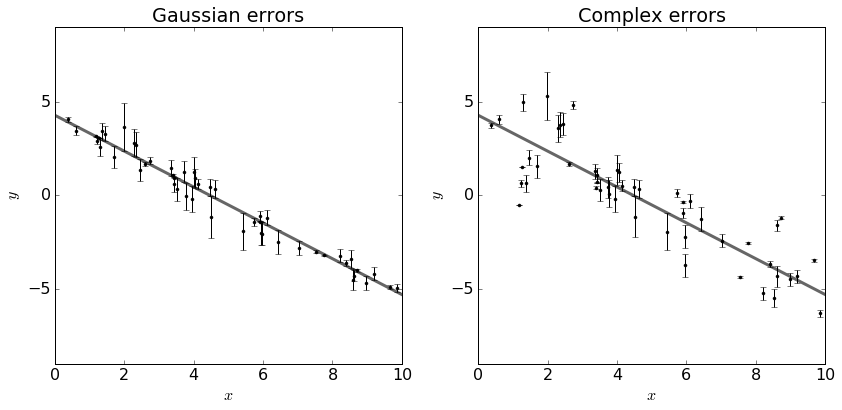

In [38]:
# Plot the dataset and the true model.
fig = plt.figure(figsize=[12,6])


xl = np.array([0, 10])

ax1 = fig.add_subplot(121)
ax1.errorbar(x, y_gauss, yerr=yerr, fmt=".k")
ax1.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
ax1.set_ylim(-9, 9)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")
ax1.set_title('Gaussian errors')

ax2 = fig.add_subplot(122)
ax2.errorbar(x, y_complex, yerr=yerr, fmt=".k")
ax2.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
ax2.set_ylim(-9, 9)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")
ax2.set_title('Complex errors')

plt.tight_layout()
plt.show()

In [39]:
# Do the least-squares fit and compute the uncertainties.
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))

b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y_gauss)))
print("""Least-squares results for Gaussian errors:
    m = {0} ± {1} (truth: {2})
    b = {3} ± {4} (truth: {5})
""".format(m_ls, np.sqrt(cov[1, 1]), m_true, b_ls, np.sqrt(cov[0, 0]), b_true))

b_ls2, m_ls2 = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y_complex)))
print("""Least-squares results for complex errors:
    m = {0} ± {1} (truth: {2})
    b = {3} ± {4} (truth: {5})
""".format(m_ls2, np.sqrt(cov[1, 1]), m_true, b_ls2, np.sqrt(cov[0, 0]), b_true))

Least-squares results for Gaussian errors:
    m = -0.960236424726 ± 0.00371578098165 (truth: -0.9594)
    b = 4.29119054051 ± 0.00575772657718 (truth: 4.294)

Least-squares results for complex errors:
    m = -0.476878332505 ± 0.00371578098165 (truth: -0.9594)
    b = 1.77609961624 ± 0.00575772657718 (truth: 4.294)



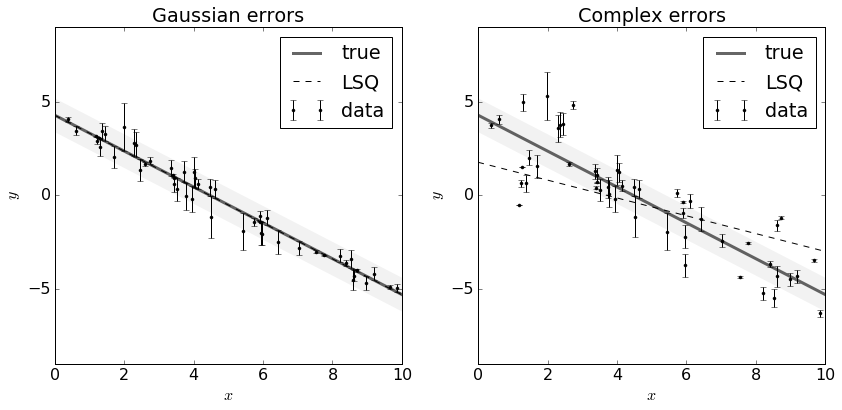

In [40]:
# Plot the dataset and the true model and leqst-square fits
fig = plt.figure(figsize=[12,6])


xl = np.array([0, 10])

# Gaussian
ax1 = fig.add_subplot(121)
# shaded region to show errors
ax1.plot(xl, m_true*xl+b_true, "k", lw=30, alpha=0.05)
# Plot data and theory
ax1.errorbar(x, y_gauss, yerr=yerr, fmt=".k",label='data')
ax1.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6,label='true')
# Plot the least-squares result.
ax1.plot(xl, m_ls*xl+b_ls, "--k",label='LSQ')
ax1.legend()
ax1.set_ylim(-9, 9)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")
ax1.set_title('Gaussian errors')

# Complex
ax2 = fig.add_subplot(122)
# shaded region to show errors
ax2.plot(xl, m_true*xl+b_true, "k", lw=30, alpha=0.05)
# Plot data and theory
ax2.errorbar(x, y_complex, yerr=yerr, fmt=".k",label='data')
ax2.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6,label='true')
# Plot the least-squares result.
ax2.plot(xl, m_ls2*xl+b_ls2, "--k",label='LSQ')
ax2.legend()
ax2.set_ylim(-9, 9)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")
ax2.set_title('Complex errors')

plt.tight_layout()
plt.show()


### Maximum likelihood

In [41]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [42]:
# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)

result = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y_gauss, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print("""Maximum likelihood result for Gaussian errors:
    m = {0} (truth: {1})
    b = {2} (truth: {3})
    f = {4} (truth: {5})
""".format(m_ml, m_true, b_ml, b_true, np.exp(lnf_ml), f_true))

result2 = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y_complex, yerr))
m_ml2, b_ml2, lnf_ml2 = result2["x"]
print("""Maximum likelihood result for Complex errors:
    m = {0} (truth: {1})
    b = {2} (truth: {3})
    f = {4} (truth: {5})
""".format(m_ml2, m_true, b_ml2, b_true, np.exp(lnf_ml2), f_true))

Maximum likelihood result for Gaussian errors:
    m = -0.9602364385 (truth: -0.9594)
    b = 4.29119055168 (truth: 4.294)
    f = 4.34286838732e-07 (truth: 0.534)

Maximum likelihood result for Complex errors:
    m = -0.913766763267 (truth: -0.9594)
    b = 4.25142936202 (truth: 4.294)
    f = 0.631783358577 (truth: 0.534)



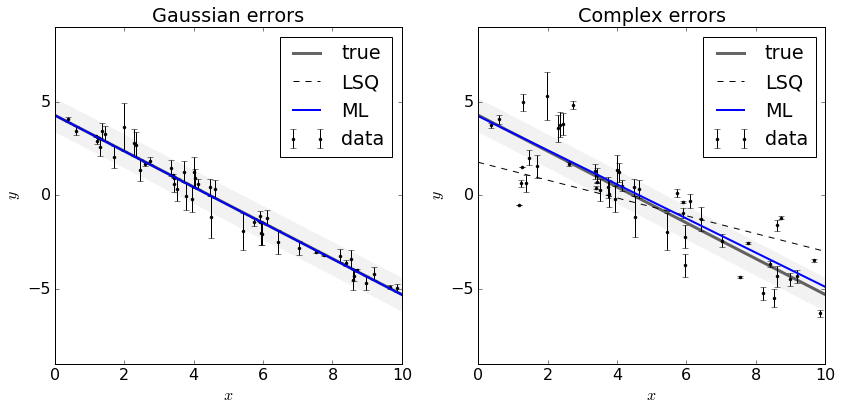

In [43]:
# Plot the dataset and the true model and leqst-square fits
fig = plt.figure(figsize=[12,6])

xl = np.array([0, 10])

# Gaussian
ax1 = fig.add_subplot(121)
# shaded region to show errors
ax1.plot(xl, m_true*xl+b_true, "k", lw=30, alpha=0.05)
# Plot data and theory
ax1.errorbar(x, y_gauss, yerr=yerr, fmt=".k",label='data')
ax1.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6,label='true')
# Plot the least-squares result.
ax1.plot(xl, m_ls*xl+b_ls, "--k",label='LSQ')
# Plot the maximum likelihood result.
ax1.plot(xl, m_ml*xl+b_ml, "b", lw=2, label='ML')
ax1.legend()
ax1.set_ylim(-9, 9)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")
ax1.set_title('Gaussian errors')

# Complex
ax2 = fig.add_subplot(122)
# shaded region to show errors
ax2.plot(xl, m_true*xl+b_true, "k", lw=30, alpha=0.05)
# Plot data and theory
ax2.errorbar(x, y_complex, yerr=yerr, fmt=".k",label='data')
ax2.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6,label='true')
# Plot the least-squares result.
ax2.plot(xl, m_ls2*xl+b_ls2, "--k",label='LSQ')
# Plot the maximum likelihood result.
ax2.plot(xl, m_ml2*xl+b_ml2, "b", lw=2, label='ML')
ax2.legend()
ax2.set_ylim(-9, 9)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")
ax2.set_title('Complex errors')

plt.tight_layout()
plt.show()